In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Basics").getOrCreate()

In [5]:
df = spark.read.csv("MCI_2014_to_2019.csv", sep=",", header=True, inferSchema=True)

In [6]:
df.show(truncate=False)

+-----------------+----------------+------+---------------+----------------------+----------------------+-----------+--------+-------+------------------------------+------------+-------------+-----------+-----------------+-----------------+------------+--------------+---------------+-------------+-------------------+-------------------+--------------+---------------+--------+-------+-------------------------------+----------+-------+--------+
|X                |Y               |Index_|event_unique_id|occurrencedate        |reporteddate          |premisetype|ucr_code|ucr_ext|offence                       |reportedyear|reportedmonth|reportedday|reporteddayofyear|reporteddayofweek|reportedhour|occurrenceyear|occurrencemonth|occurrenceday|occurrencedayofyear|occurrencedayofweek|occurrencehour|MCI            |Division|Hood_ID|Neighbourhood                  |Lat       |Long   |ObjectId|
+-----------------+----------------+------+---------------+----------------------+----------------------+-

In [7]:
df.dtypes

[('X', 'double'),
 ('Y', 'double'),
 ('Index_', 'int'),
 ('event_unique_id', 'string'),
 ('occurrencedate', 'string'),
 ('reporteddate', 'string'),
 ('premisetype', 'string'),
 ('ucr_code', 'int'),
 ('ucr_ext', 'int'),
 ('offence', 'string'),
 ('reportedyear', 'int'),
 ('reportedmonth', 'string'),
 ('reportedday', 'int'),
 ('reporteddayofyear', 'int'),
 ('reporteddayofweek', 'string'),
 ('reportedhour', 'int'),
 ('occurrenceyear', 'int'),
 ('occurrencemonth', 'string'),
 ('occurrenceday', 'int'),
 ('occurrencedayofyear', 'int'),
 ('occurrencedayofweek', 'string'),
 ('occurrencehour', 'int'),
 ('MCI', 'string'),
 ('Division', 'string'),
 ('Hood_ID', 'int'),
 ('Neighbourhood', 'string'),
 ('Lat', 'double'),
 ('Long', 'double'),
 ('ObjectId', 'int')]

In [25]:
from pyspark.sql import functions as func
from pyspark.sql.functions import *

df1 = df.withColumn('date_only', split(df['reporteddate'], ' ').getItem(0))
df1.show(truncate=False)

+-----------------+----------------+------+---------------+----------------------+----------------------+-----------+--------+-------+------------------------------+------------+-------------+-----------+-----------------+-----------------+------------+--------------+---------------+-------------+-------------------+-------------------+--------------+---------------+--------+-------+-------------------------------+----------+-------+--------+----------+
|X                |Y               |Index_|event_unique_id|occurrencedate        |reporteddate          |premisetype|ucr_code|ucr_ext|offence                       |reportedyear|reportedmonth|reportedday|reporteddayofyear|reporteddayofweek|reportedhour|occurrenceyear|occurrencemonth|occurrenceday|occurrencedayofyear|occurrencedayofweek|occurrencehour|MCI            |Division|Hood_ID|Neighbourhood                  |Lat       |Long   |ObjectId|date_only |
+-----------------+----------------+------+---------------+----------------------+--

In [19]:
grouped_df = df1.groupBy("date_only").count()
grouped_df.sort(func.col("date_only")).show(truncate=False)

+----------+-----+
|date_only |count|
+----------+-----+
|2014/01/01|100  |
|2014/01/02|65   |
|2014/01/03|53   |
|2014/01/04|64   |
|2014/01/05|74   |
|2014/01/06|68   |
|2014/01/07|92   |
|2014/01/08|86   |
|2014/01/09|82   |
|2014/01/10|64   |
|2014/01/11|62   |
|2014/01/12|92   |
|2014/01/13|80   |
|2014/01/14|82   |
|2014/01/15|68   |
|2014/01/16|74   |
|2014/01/17|94   |
|2014/01/18|94   |
|2014/01/19|70   |
|2014/01/20|80   |
+----------+-----+
only showing top 20 rows



In [22]:
import pandas as pd

pandas_df = grouped_df.toPandas()
pandas_df = pandas_df.rename(columns={"date_only": "ds", "count": "y"})
pandas_df.sort_values(by=['ds']).head(20)

,ds,y
283,2014/01/01,100
933,2014/01/02,65
96,2014/01/03,53
1132,2014/01/04,64
1295,2014/01/05,74
1664,2014/01/06,68
1785,2014/01/07,92
175,2014/01/08,86
2141,2014/01/09,82
1614,2014/01/10,64


In [23]:
from fbprophet import Prophet

model = Prophet()
model.fit(pandas_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future_df = model.make_future_dataframe(periods=365)
future_df

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
2551,2020-12-26
2552,2020-12-27
2553,2020-12-28
2554,2020-12-29


In [26]:
predictions = model.predict(future_df)
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,85.782903,58.391765,90.926080,85.782903,85.782903,-11.740086,-11.740086,-11.740086,-0.277726,-0.277726,-0.277726,-11.462360,-11.462360,-11.462360,0.0,0.0,0.0,74.042817
1,2014-01-02,85.787710,57.702803,89.467008,85.787710,85.787710,-12.178041,-12.178041,-12.178041,-1.070985,-1.070985,-1.070985,-11.107056,-11.107056,-11.107056,0.0,0.0,0.0,73.609668
2,2014-01-03,85.792516,60.725876,93.805360,85.792516,85.792516,-8.491474,-8.491474,-8.491474,2.212817,2.212817,2.212817,-10.704290,-10.704290,-10.704290,0.0,0.0,0.0,77.301042
3,2014-01-04,85.797322,57.173547,88.043594,85.797322,85.797322,-12.746473,-12.746473,-12.746473,-2.481784,-2.481784,-2.481784,-10.264689,-10.264689,-10.264689,0.0,0.0,0.0,73.050849
4,2014-01-05,85.802129,58.389414,90.279418,85.802129,85.802129,-12.128502,-12.128502,-12.128502,-2.329248,-2.329248,-2.329248,-9.799254,-9.799254,-9.799254,0.0,0.0,0.0,73.673626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2020-12-26,114.540189,84.495178,116.212042,114.174653,114.831626,-14.625169,-14.625169,-14.625169,-2.481784,-2.481784,-2.481784,-12.143385,-12.143385,-12.143385,0.0,0.0,0.0,99.915019
2552,2020-12-27,114.556217,83.249220,117.092953,114.189065,114.849363,-14.551937,-14.551937,-14.551937,-2.329248,-2.329248,-2.329248,-12.222689,-12.222689,-12.222689,0.0,0.0,0.0,100.004281
2553,2020-12-28,114.572246,89.870183,122.558681,114.203487,114.867100,-8.608835,-8.608835,-8.608835,3.603421,3.603421,3.603421,-12.212256,-12.212256,-12.212256,0.0,0.0,0.0,105.963411
2554,2020-12-29,114.588274,86.800782,118.348201,114.217909,114.884697,-11.772728,-11.772728,-11.772728,0.343505,0.343505,0.343505,-12.116233,-12.116233,-12.116233,0.0,0.0,0.0,102.815546


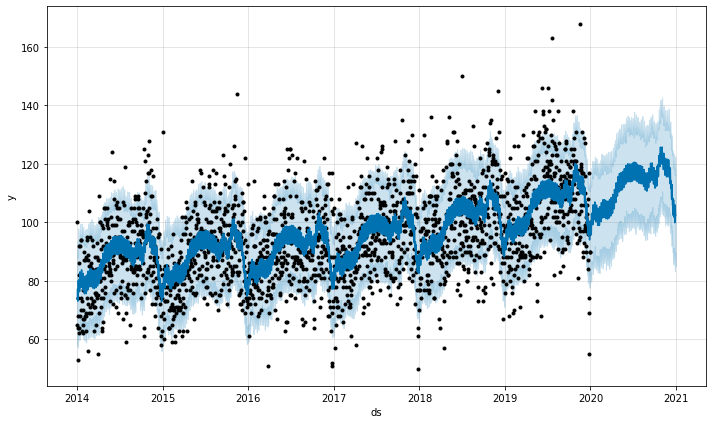

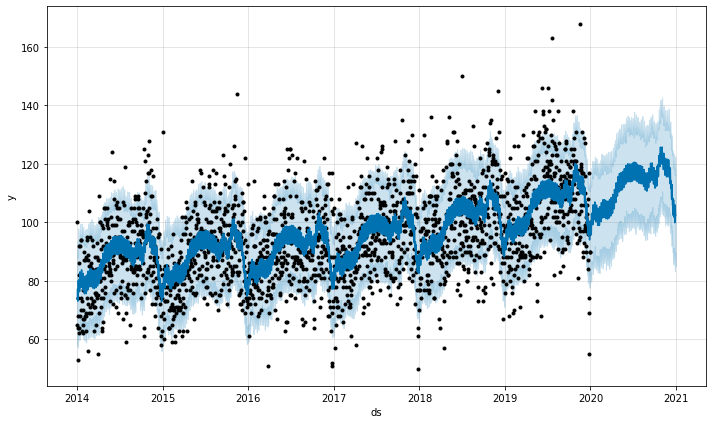

In [27]:
model.plot(predictions)